In [6]:
#Import required modules
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import torch
from utils import load_checkpoint, get_random_image_label_pair
from models.unet import UNet
from dataprep.data_preparation import add_channel_and_batch, load_dataset

In [8]:
#=========
# pass to device
# if torch.cuda.is_available:
#     print("using gpu")
#     device = torch.device("cuda")
# else:
#     print("using cpu")
#     device = torch.device("cpu")
device = torch.device("cpu")

#=========
# set model's parameters
final_activation="Sigmoid"
depth = 3
num_fmaps = 64
fmap_inc_factor = 4
downsample_factor = 2
kernel_size = 3
padding = "valid"
upsample_mode = "nearest"
unet_model = UNet(depth=depth,
                  in_channels=1,
                  out_channels=1,
                  final_activation=final_activation,
                  num_fmaps=num_fmaps,
                  fmap_inc_factor=fmap_inc_factor,
                  downsample_factor=downsample_factor,
                  kernel_size=kernel_size,
                  padding=padding,
                  upsample_mode=upsample_mode).to(device)


#load checkpoint of the model to test
checkpoint_save_path = "checkpoints"
checkpoint_key = "20241112-133730"
model = load_checkpoint(model=unet_model,
                        path=checkpoint_save_path,
                        optimizer=None,
                        key=checkpoint_key,
                        map_location=torch.device('cpu'))



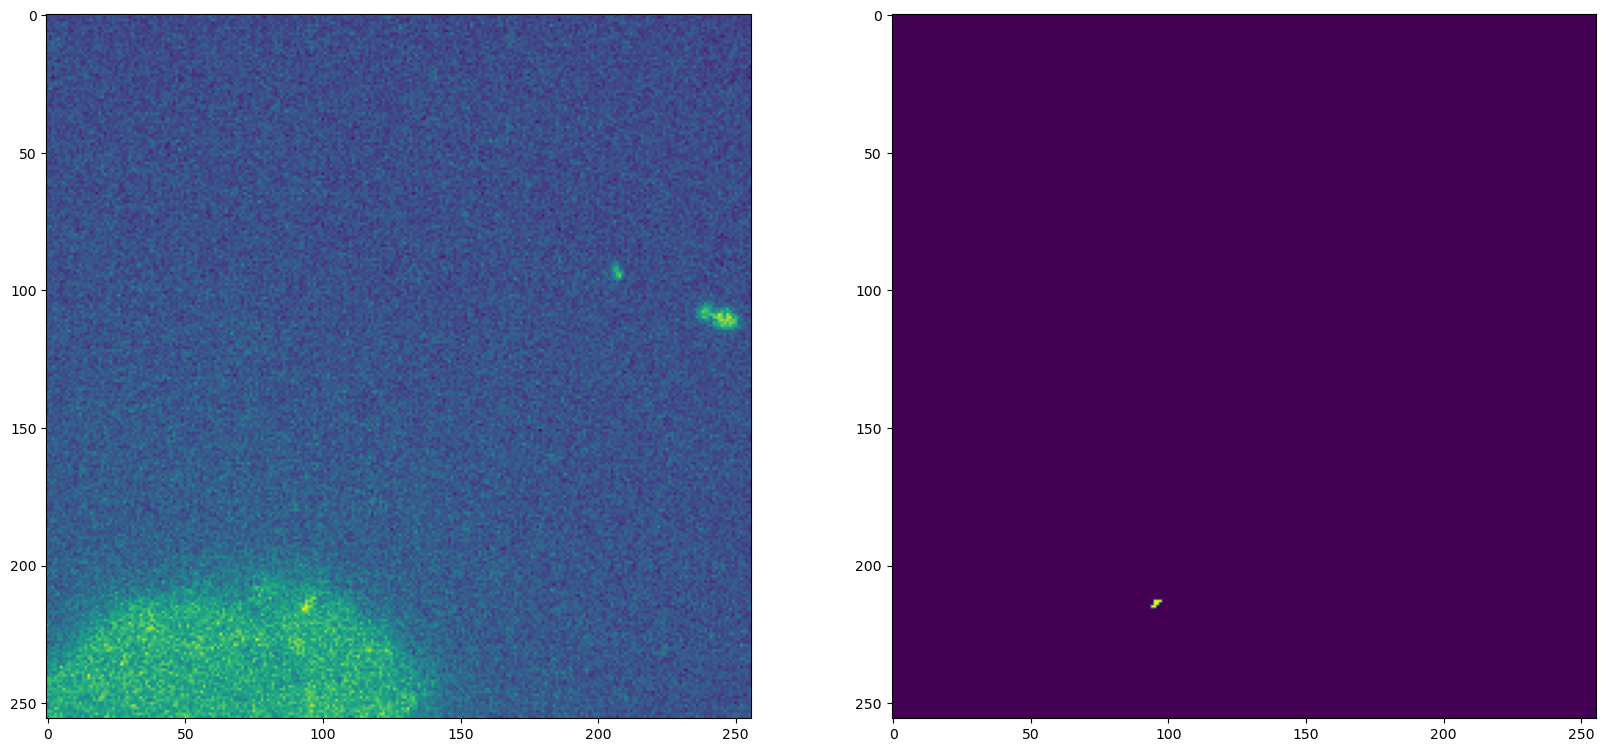

In [9]:
# torch.from_numpy(image.copy())
val_input_data_dir = r"C:\Users\aless\OneDrive\Desktop\Ale\personal\projects\pip2_segmentation\data\validation\raw"
val_label_data_dir = r"C:\Users\aless\OneDrive\Desktop\Ale\personal\projects\pip2_segmentation\data\validation\label"

val_data_set_images, val_data_set_labels = load_dataset(val_input_data_dir, val_label_data_dir)
val_data_item_np, val_label_item_np = get_random_image_label_pair(val_data_set_images, val_data_set_labels)

val_data_item_tensor = torch.from_numpy(add_channel_and_batch(val_data_item_np).copy())

fig1, ax1 = plt.subplots(1,2, figsize=(20,20))

ax1[0].imshow(val_data_item_tensor.detach().numpy()[0,0,...])
ax1[1].imshow(val_label_item_np)

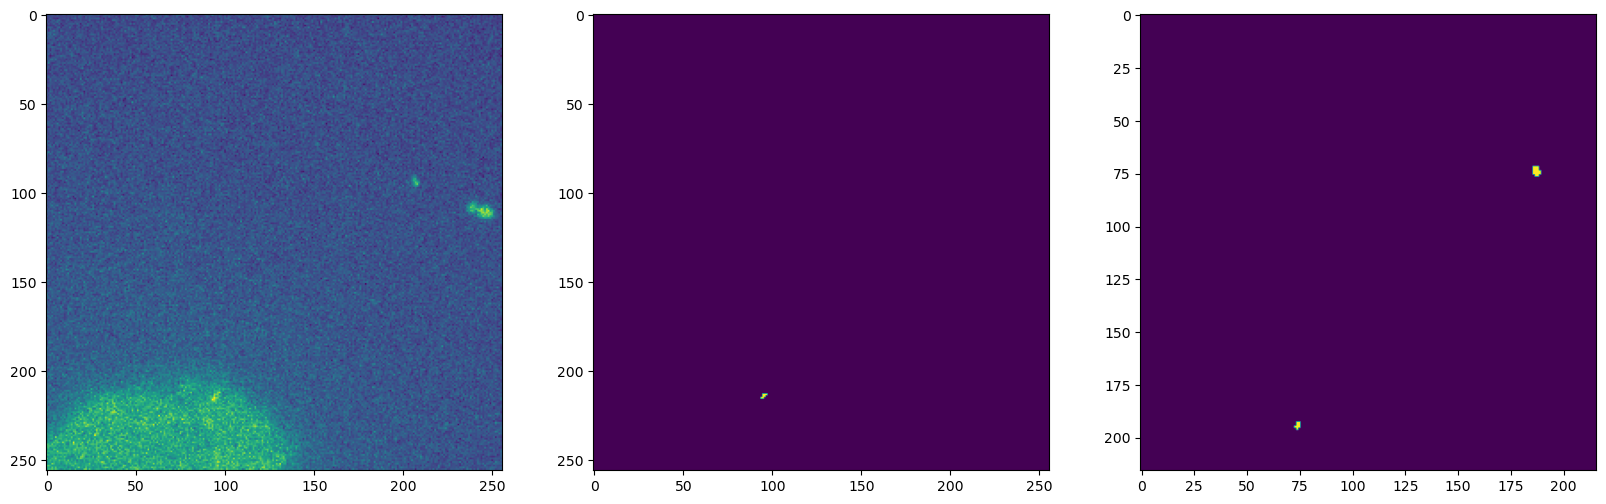

In [10]:
val_data_item_prediction = model(val_data_item_tensor)
bin_val_data_item_prediction = torch.where(val_data_item_prediction>0.5, 1,0)

fig2, ax2 = plt.subplots(1,3, figsize=(20,20))

ax2[0].imshow(val_data_item_tensor.detach().numpy()[0,0,...])
ax2[1].imshow(val_label_item_np)
ax2[2].imshow(bin_val_data_item_prediction.detach().numpy()[0,0,...])

In [18]:
saving_dir = r"C:\Users\aless\OneDrive\Desktop\Ale\personal\projects\pip2_segmentation\develop\presentation_JoshuaTalks_241114\results\20241112-133730"
for i in range(30):
    val_data_item_np, val_label_item_np = get_random_image_label_pair(val_data_set_images, val_data_set_labels)
    val_data_item_tensor = torch.from_numpy(add_channel_and_batch(val_data_item_np).copy())
    val_data_item_prediction = model(val_data_item_tensor)
    bin_val_data_item_prediction = torch.where(val_data_item_prediction>0.5, 255,0)
    saving_name_raw = f"{checkpoint_key}_raw_{i}.tif"
    saving_name_label = f"{checkpoint_key}_label_{i}.tif"
    saving_name_prediction = f"{checkpoint_key}_prediction_{i}.tif"

    tifffile.imwrite(os.path.join(saving_dir, saving_name_raw), val_data_item_np)
    tifffile.imwrite(os.path.join(saving_dir, saving_name_label), val_label_item_np)
    tifffile.imwrite(os.path.join(saving_dir, saving_name_prediction), bin_val_data_item_prediction.detach().numpy()[0,0,...].astype(np.uint8))


